In [64]:
%config StoreMagics.autorestore = True
%reset -f
# %store -z
%store -r
%whos

Variable                    Type              Data/Info
-------------------------------------------------------
dvMathcalP                  LinearIOSystem    <LinearIOSystem>: sys[13]<...>[[0. 0.]\n     [0. 0.]]\n
extMathcalP                 LinearIOSystem    <LinearIOSystem>: sys[12]<...> [0. 0.]\n     [0. 0.]]\n
idx_results_multiord_list   list              n=130
mathcalP                    LinearIOSystem    <LinearIOSystem>: sys[10]<...>[[0. 0.]\n     [0. 0.]]\n
mathcalP_cb                 LinearIOSystem    <LinearIOSystem>: sys[10]<...>[[0. 0.]\n     [0. 0.]]\n


In [65]:
import numpy
import sympy
import scipy
import control
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

import multiprocessing
from joblib import Parallel, delayed  
from tqdm.notebook import tqdm
import psutil

from custom_utils import ControlUtils
from custom_utils import ODEUtils

from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML

numpy.set_printoptions(precision=3)
sympy.init_printing(use_latex='mathjax', use_unicode=True)
sympy.init_printing()
plt.rcParams.update({ "text.usetex": True, "font.family": "Helvetica", "axes.titley": 1.0 } )
%matplotlib inline

In [66]:
# Controller definition
Kp = 80e-6
Td = 10e0
N = 1.0e3
num =  [ Kp*((Td/N)+Td), Kp ]
den = [ (Td/N), 1 ]
mathcalC = control.tf2ss(num,den)

# s variable
s = control.TransferFunction.s

# Norm operator Delta
mathcalCPrime = control.ss(mathcalC.A,mathcalC.B,mathcalC.C,numpy.zeros(mathcalC.D.shape))
tfMathcalCPrime = control.ss2tf(mathcalCPrime)

normInfmathcalC = ControlUtils.hinfnorm(mathcalC)
normInfMathcalCPrime = ControlUtils.hinfnorm(tfMathcalCPrime)
normInfsMathcalCPrime = ControlUtils.hinfnorm(s * tfMathcalCPrime)
                        
# Controller matrices
Ac = mathcalC.A
Bv = mathcalC.B
Cw = mathcalC.C
Dw = mathcalC.D

# FOM extended plant
Ap = extMathcalP.A
Bw = extMathcalP.B[:,0:1]
Bu = extMathcalP.B[:,1:2]
Cv = extMathcalP.C[0:1,:]
Cy = extMathcalP.C[-1:,:]
Dv = extMathcalP.D[0:1,:]
Dy = extMathcalP.D[-1:,:]

# Closed-loop with FOM Extended Plant
extAcl = numpy.row_stack( [ numpy.column_stack( [ Ap + Bw@Dw@Cv, Bw@Cw ] ),
                                numpy.column_stack( [ Bv@Cv, Ac ] )
                                ] )
extBcl = numpy.row_stack( [ numpy.column_stack([Bw, Bu]),
                                numpy.column_stack( [ numpy.zeros( (Ac.shape[0],Bw.shape[1]) ), numpy.zeros( (Ac.shape[0],Bu.shape[1]) ) ] )
                                ] )
extCcl = numpy.row_stack( [ numpy.column_stack( [ Cv, numpy.zeros( (Cv.shape[0],Ac.shape[0]) ) ] ),
                                numpy.column_stack( [ Cv@Ap + Cv@Bw@Dw@Cv, Cv@Bw@Cw ] ),
                                numpy.column_stack( [ Cy, numpy.zeros( (Cy.shape[0],Ac.shape[0]) ) ] )
                                ] )
extDcl = numpy.row_stack( [ numpy.column_stack( [ numpy.zeros( (Cv.shape[0],Bw.shape[1]) ), numpy.zeros( (Cv.shape[0],Bu.shape[1]) ) ] ),
                                numpy.column_stack( [ Cv@Bw , Cv@Bu] ),
                                numpy.column_stack( [ numpy.zeros( (Cy.shape[0],Bw.shape[1]) ), numpy.zeros( (Cy.shape[0],Bu.shape[1]) ) ] )
                                ] )
extMathcalPcl = control.ss(extAcl,extBcl,extCcl,extDcl)
  
# gamma_tildew_dv = ControlUtils.hinfnorm(extMathcalPcl[1,0])
gamma_tildew_dv = ControlUtils.hinfnorm(extMathcalPcl)

# Creating balanced form

# Getting Grammians (Factorized, check documentation for control.gram(.,'cf'/'of'))
WcL = numpy.array( control.gram(extMathcalP,'cf'), dtype=numpy.longdouble ).T
WoL = numpy.array( control.gram(extMathcalP,'of'), dtype=numpy.longdouble ).T

# Getting SVD
U, S2, V = numpy.linalg.svd(WcL.T @ (WoL @ WoL.T) @ WcL, compute_uv=True)
S = numpy.diag( S2**(1/2) )

# Getting transformation
T = ( (S**(1/2)) @ U.T ) @ numpy.linalg.inv(WcL)
invT = numpy.linalg.inv(T)

# Computing balanced Grammians
WcBal = T @ (WcL @ WcL.T) @ T.T
WoBal = invT.T @ (WoL @ WoL.T) @ invT

# Getting Hankel singular values
hsv = numpy.linalg.eigvals(WcBal@WoBal)**(1/2)
                              
def smallgain_condition(Tsam,reduction_order):
        # Creating Projection Matrices
        proj = numpy.row_stack([numpy.eye(reduction_order,reduction_order), numpy.zeros((extMathcalP.A.shape[0]-reduction_order,reduction_order))])
        V_proj = invT @ proj
        WT_proj = proj.T @ T

        # Get ROM matrices
        A_red = WT_proj @ extMathcalP.A @ V_proj
        B_red = WT_proj @ extMathcalP.B
        C_red = extMathcalP.C @ V_proj

        # Create ROM
        # sys_red = control.ss(A_red,B_red,C_red,sys.D)
        # return sys_red, hsv, (T,proj,V_proj,WT_proj) # type: ignore

        truncExtAp = A_red
        truncExtBw = B_red[:,0:1]
        truncExtBu = B_red[:,1:2]
        truncExtCv = C_red[0:1,:]
        truncExtCy = C_red[-1:,:]
        truncExtDv = extMathcalP.D[0:1,:]
        truncExtDy = extMathcalP.D[-1:,:]
        
        # Perform reduction to obtain ROM extended plant
        # truncExtMathcalP, hsvExtMathcalP, _ = ControlUtils.balaced_truncation(extMathcalP, reduction_order)
        # normInfTruncExtMathcalP = ControlUtils.hinfnorm(truncExtMathcalP)
        # display(Math('\\lVert \\widehat{\\mathcal{P}_{ext}} \\rVert_{\\infty} = ' + str(normInfTruncExtMathcalP)))
        
        #######################################################################
        # # Perform reduction to obtain ROM extended plant
        # truncExtMathcalP, hsvExtMathcalP, _ = ControlUtils.balaced_truncation(extMathcalP, reduction_order)
        # normInfTruncExtMathcalP = ControlUtils.hinfnorm(truncExtMathcalP)
        # display(Math('\\lVert \\widehat{\\mathcal{P}_{ext}} \\rVert_{\\infty} = ' + str(normInfTruncExtMathcalP)))
        # truncExtAp = truncExtMathcalP.A
        # truncExtBw = truncExtMathcalP.B[:,0:1]
        # truncExtBu = truncExtMathcalP.B[:,1:2]
        # truncExtCv = truncExtMathcalP.C[0:1,:]
        # truncExtCy = truncExtMathcalP.C[-1:,:]
        # truncExtDv = truncExtMathcalP.D[0:1,:]
        # truncExtDy = truncExtMathcalP.D[-1:,:]
        
        # Closed-loop with ROM Extended Plant
        truncExtAcl = numpy.row_stack( [ numpy.column_stack( [ truncExtAp + truncExtBw@Dw@truncExtCv, truncExtBw@Cw ] ),
                                    numpy.column_stack( [ Bv@truncExtCv, Ac ] )
                                    ] )
        truncExtBcl = numpy.row_stack( [ numpy.column_stack([truncExtBw, truncExtBu]),
                                    numpy.column_stack( [ numpy.zeros( (Ac.shape[0],truncExtBw.shape[1]) ), numpy.zeros( (Ac.shape[0],truncExtBu.shape[1]) ) ] )
                                    ] )
        truncExtCcl = numpy.row_stack( [ numpy.column_stack( [ truncExtCv, numpy.zeros( (truncExtCv.shape[0],Ac.shape[0]) ) ] ),
                                    numpy.column_stack( [ truncExtCv@truncExtAp + truncExtCv@truncExtBw@Dw@truncExtCv, truncExtCv@truncExtBw@Cw ] ),
                                    numpy.column_stack( [ truncExtCy, numpy.zeros( (truncExtCy.shape[0],Ac.shape[0]) ) ] )
                                    ] )
        truncExtDcl = numpy.row_stack( [ numpy.column_stack( [ numpy.zeros( (truncExtCv.shape[0],truncExtBw.shape[1]) ), numpy.zeros( (truncExtCv.shape[0],truncExtBu.shape[1]) ) ] ),
                                    numpy.column_stack( [ truncExtCv@truncExtBw , truncExtCv@truncExtBu] ),
                                    numpy.column_stack( [ numpy.zeros( (truncExtCy.shape[0],truncExtBw.shape[1]) ), numpy.zeros( (truncExtCy.shape[0],truncExtBu.shape[1]) ) ] )
                                    ] )
        truncExtMathcalPcl = control.ss(truncExtAcl,truncExtBcl,truncExtCcl,truncExtDcl)
        
        #######################################################################
        
        # Computing approximation error (Other form is to use the max hsvExtMathcalP)
        approxErrorExtMathcalPcl = extMathcalPcl-truncExtMathcalPcl
        
        #######################################################################
        # Computing norms for small-gain stability condition
        # epsilon_tildew_dv = ControlUtils.hinfnorm(approxErrorExtMathcalPcl[1,0])
        epsilon_tildew_dv = ControlUtils.hinfnorm(approxErrorExtMathcalPcl)
        
        normInfDelta = 2*Tsam/numpy.pi
        gamma_dv_tildew = normInfDelta * normInfmathcalC \
                        + normInfDelta * normInfsMathcalCPrime * normInfDelta \
                        + normInfMathcalCPrime * normInfDelta
        
        return (epsilon_tildew_dv,gamma_dv_tildew,truncExtMathcalPcl,approxErrorExtMathcalPcl)

In [67]:
# Sampling time grid, numericas are too sensitive
# samplings_lims = [900.0e-3,920.0e-3]
samplings_lims = [790.0e-3,840.0e-3]
samplings_steps = 50
# samplings_steps = 5
samplings = numpy.linspace(samplings_lims[0],samplings_lims[1],samplings_steps)

reduction_order_lims = [5,25]
# reduction_order_steps = 5
reduction_order_steps = 50
reduction_order_steps = reduction_order_lims[1]-reduction_order_lims[0]+1
reduction_orders = numpy.linspace(reduction_order_lims[0],reduction_order_lims[1],reduction_order_steps)
# print(reduction_orders)

# Creation of arguements lists for the parallel execution of function smallgain_condition(*args)
idx_args_list = []
for i in range(samplings_steps):
    for j in range(reduction_order_steps):
        Tsam = samplings[i]
        reduc_order = reduction_orders[j]
        # Kp = kps[j]
        # Td = tds[j]
        
        # num =  [ (Kp/Td) * N * (N + Td), (Kp/Td) * N * (1.0/Td) ]
        # den = [ 1, N/Td ]
        # num =  [ Kp*((Td/N)+Td), Kp ]
        # den = [ (Td/N), 1 ]
        # mathcalC = control.tf2ss(num,den)

        idx_args_list.append([(i,j),(Tsam,int(reduc_order))])

# Execution of jobs using multiprocess managed by Parallel 
# (Very recommended since standard python multithread does not take advantage of all cores due to GIL)
# (The other option is to use CPython)
num_cores = multiprocessing.cpu_count()
idx_results_multiord_list = Parallel(n_jobs=num_cores)\
                        (\
                            delayed( lambda idx,args: (idx, smallgain_condition(*args)) )\
                                ( idx_args_list[k][0], idx_args_list[k][1] )\
                                for k in tqdm(range(len(idx_args_list)), position=0)\
                        )
                

  0%|          | 0/1050 [00:00<?, ?it/s]

In [68]:
# print(hsv)

# for k in range(len(idx_results_list)):
#     (i,j),(epsilon_tildew_dv,gamma_dv_tildew,truncExtMathcalPcl,approxErrorExtMathcalPcl) = idx_results_list[k]
#     print(ControlUtils.hinfnorm(approxErrorExtMathcalPcl))
    

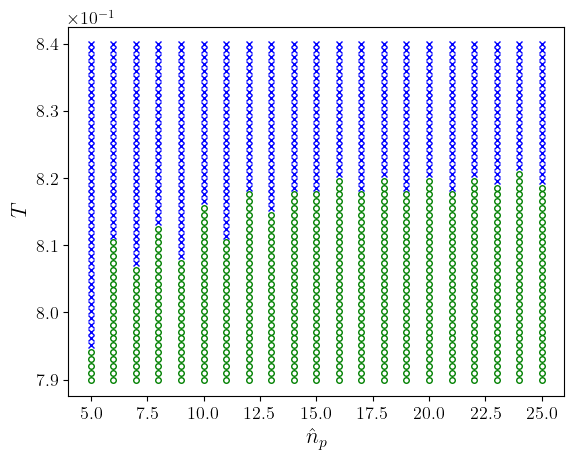

<Figure size 640x480 with 0 Axes>

In [69]:
for k in range(len(idx_results_multiord_list)):
    (i,j),(epsilon_tildew_dv,gamma_dv_tildew,truncExtMathcalPcl,approxErrorExtMathcalPcl) = idx_results_multiord_list[k]
    
    # Recover sampling and reduction order
    Tsam = samplings[i]
    reduc_order = reduction_orders[j]
    
    # epsilon_tildew_dv = sum(hsvExtMathcalP[reduc_order+1:])
    small_gain_cond_FOM = gamma_tildew_dv*gamma_dv_tildew
    small_gain_cond_ROM = (gamma_tildew_dv+epsilon_tildew_dv)*gamma_dv_tildew

    # if(small_gain_cond_FOM>=1):
    #      plt.plot(reduc_order, Tsam, marker="x", markersize=4, markerfacecolor='r', markeredgecolor='r')
    if(small_gain_cond_ROM>=1):
        plt.plot(reduc_order, Tsam, marker="x", markersize=4, markerfacecolor='b', markeredgecolor='b')
    else:
        plt.plot(reduc_order, Tsam, marker="o", markersize=4, markerfacecolor='none', markeredgecolor='g')

plt.ticklabel_format(axis='y', scilimits=(-0,-0))
# plt.ticklabel_format(axis='x', scilimits=(0,1))
plt.tick_params(axis='y', labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.gca().yaxis.get_offset_text().set_fontsize(13)
plt.gca().xaxis.get_offset_text().set_fontsize(13)
plt.ylabel('$T$', fontsize=16)
plt.xlabel('$\\hat{n}_p$', fontsize=16)
plt.show()
plt.savefig('reduction_vs_sampling.png')

In [70]:
%store -d idx_results_multiord_list
%store idx_results_multiord_list

Stored 'idx_results_multiord_list' (list)
